# **2.1: TRAIN A NETWORK FROM SCRATCH FOR MASSES AND CALCIFICATION**



## Set up environment 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
import os
import datetime
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import itertools

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import class_weight

np.random.seed(42)
tf.random.set_seed(42)


2.4.0


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

## Prepare Learning Dataset





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
 
images, labels= load_training()
images = np.expand_dims(images, axis = 3)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

test_images, test_labels = load_test()
test_images = np.expand_dims(test_images, axis = 3)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

Training set loaded
Images:(5352, 150, 150, 1)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 1)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Extract all abnormalities indexes
abn_indexes = np.where(labels != 0)

#Extract all anormalities images
abn_images = images[abn_indexes]
abn_labels = labels[abn_indexes]

#Change labels according to Mass and Calcification
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 2), 0, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 3, abn_labels == 4), 1, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)

train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()


print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")


Training/Validation set split.
Train Images:(2140, 150, 150, 1)
Train Labels:(2140,)
983 belonging to class 0 in the training set
1157 belonging to class 1 in the training set

Validation Images:(536, 150, 150, 1)
Validation Labels:(536,)
235 belonging to class 0 in the validation set
301 belonging to class 1 in the validation set


In [ ]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Mass and Calcification
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 2), 0, test_labels)
test_labels = np.where(np.logical_or(test_labels == 3, test_labels == 4), 1, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 150, 150, 1)
Test Labels:(336,)
179 belonging to class 0 in the test set
157 belonging to class 1 in the test set


In [ ]:
#Data Preprocessing
BATCH_SIZE = 32

#train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./65535)


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./65535,
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)


train_dataset = train_datagen.flow(
    train_images, 
    train_labels,
    batch_size=BATCH_SIZE, 
    shuffle = True
)

validation_dataset = test_datagen.flow(
    validation_images, 
    validation_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

#SimpleCNN

In [ ]:
#Define a new model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 1)))                
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Name the model 
network_name = 'SimpleCNN_5.h5'
network_name_best = 'SimpleCNN_5_best.h5'


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/100
67/67 [==============================] - 13s 82ms/step - loss: 0.6923 - acc: 0.5450 - val_loss: 0.6889 - val_acc: 0.5616
Epoch 2/100
67/67 [==============================] - 5s 71ms/step - loss: 0.6915 - acc: 0.5343 - val_loss: 0.6872 - val_acc: 0.5616
Epoch 3/100
67/67 [==============================] - 5s 70ms/step - loss: 0.6901 - acc: 0.5392 - val_loss: 0.6863 - val_acc: 0.5616
Epoch 4/100
67/67 [==============================] - 5s 70ms/step - loss: 0.6905 - acc: 0.5295 - val_loss: 0.6844 - val_acc: 0.5616
Epoch 5/100
67/67 [==============================] - 5s 70ms/step - loss: 0.6892 - acc: 0.5286 - val_loss: 0.6826 - val_acc: 0.5616
Epoch 6/100
67/67 [==============================] - 5s 70ms/step - loss: 0.6865 - acc: 0.5330 - val_loss: 0.6798 - val_acc: 0.5616
Epoch 7/100
67/67 [==============================] - 5s 71ms/step - loss: 0.6837 - acc: 0.5429 - val_loss: 0.6753 - val_acc: 0.5616
Epoch 8/100
67/67 [==============================] - 5s 71ms/step - loss: 0

##MODEL EVALUATION

### Evaluation on validation set

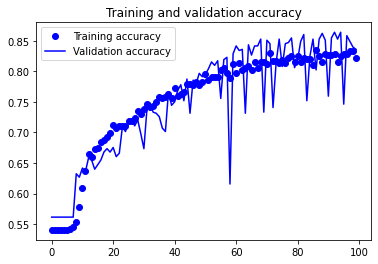

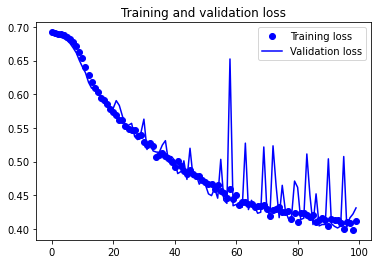

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 24ms/step - loss: 0.4382 - acc: 0.7946
0.7946428656578064
[[124  55]
 [ 14 143]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 12ms/step - loss: 0.3956 - acc: 0.8244
0.824404776096344
[[152  27]
 [ 32 125]]


#Vgg16

In [ ]:
vgg = VGG16(weights=None,
                  include_top=False,
                  input_shape=(150, 150, 1))
model = models.Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Name the model 
network_name = 'vgg16_t.h5'
network_name_best = 'vgg16_5_best.h5'


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14713536  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 18,908,865
Trainable params: 18,908,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=200,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/200
67/67 [==============================] - 27s 347ms/step - loss: 0.7420 - acc: 0.5249 - val_loss: 0.6898 - val_acc: 0.5616
Epoch 2/200
67/67 [==============================] - 20s 296ms/step - loss: 0.6922 - acc: 0.5478 - val_loss: 0.6875 - val_acc: 0.5616
Epoch 3/200
67/67 [==============================] - 20s 298ms/step - loss: 0.6902 - acc: 0.5447 - val_loss: 0.6884 - val_acc: 0.5616
Epoch 4/200
67/67 [==============================] - 20s 298ms/step - loss: 0.6919 - acc: 0.5374 - val_loss: 0.6870 - val_acc: 0.5616
Epoch 5/200
67/67 [==============================] - 20s 297ms/step - loss: 0.6956 - acc: 0.5274 - val_loss: 0.6870 - val_acc: 0.5728
Epoch 6/200
67/67 [==============================] - 20s 298ms/step - loss: 0.6866 - acc: 0.5380 - val_loss: 0.6856 - val_acc: 0.5616
Epoch 7/200
67/67 [==============================] - 20s 297ms/step - loss: 0.6865 - acc: 0.5462 - val_loss: 0.6854 - val_acc: 0.5616
Epoch 8/200
67/67 [==============================] - 20s 297ms

##MODEL EVALUATION

###Evaluation on validation set

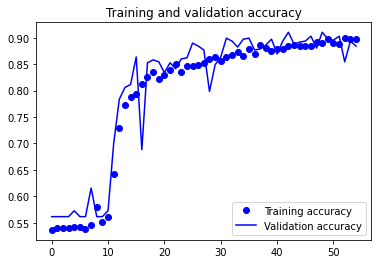

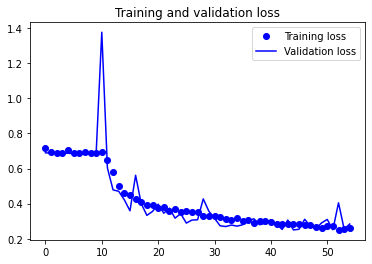

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 2s 144ms/step - loss: 0.3647 - acc: 0.8304
0.8303571343421936
[[134  45]
 [ 12 145]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 1s 82ms/step - loss: 0.3562 - acc: 0.8482
0.8482142686843872
[[146  33]
 [ 18 139]]


11/11 [==============================] - 1s 63ms/step - loss: 0.3064 - acc: 0.8810
0.8809523582458496
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       179
           1       0.85      0.90      0.88       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336



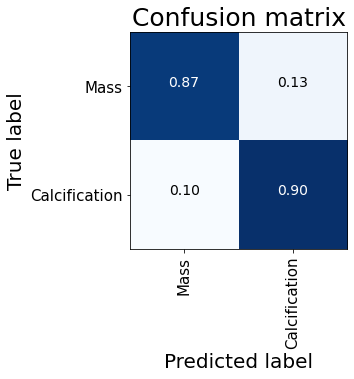

In [ ]:
network_name = "vgg16_4.h5"
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
model = keras.models.load_model(os.path.join(path, network_name))
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))


#SimpleAlexNet

In [ ]:
#Define a new model

model = models.Sequential()
model.add(layers.Conv2D(96, (3, 3), activation='relu',
                        input_shape=(150, 150, 1)))                
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.000001), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
#Name the model 
network_name = 'SimpleAlexNet_10.h5'
network_name_best = 'SimpleAlexNet_10_best.h5'

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.00001),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 96)      960       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 256)       221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       884992    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 256)       0

In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=100,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/100
67/67 [==============================] - 11s 137ms/step - loss: 0.6967 - acc: 0.5397 - val_loss: 0.6921 - val_acc: 0.5616
Epoch 2/100
67/67 [==============================] - 7s 110ms/step - loss: 0.6952 - acc: 0.5385 - val_loss: 0.6904 - val_acc: 0.5616
Epoch 3/100
67/67 [==============================] - 7s 110ms/step - loss: 0.6937 - acc: 0.5481 - val_loss: 0.6884 - val_acc: 0.5616
Epoch 4/100
67/67 [==============================] - 7s 110ms/step - loss: 0.6939 - acc: 0.5440 - val_loss: 0.6821 - val_acc: 0.5616
Epoch 5/100
67/67 [==============================] - 7s 111ms/step - loss: 0.6843 - acc: 0.5703 - val_loss: 0.6723 - val_acc: 0.5616
Epoch 6/100
67/67 [==============================] - 8s 112ms/step - loss: 0.6822 - acc: 0.5869 - val_loss: 0.6613 - val_acc: 0.6399
Epoch 7/100
67/67 [==============================] - 8s 112ms/step - loss: 0.6672 - acc: 0.6100 - val_loss: 0.6455 - val_acc: 0.6922
Epoch 8/100
67/67 [==============================] - 8s 112ms/step -

## MODEL EVALUATION

### Evaluation on validation set

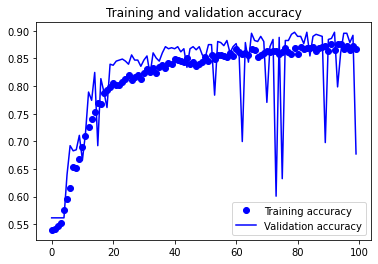

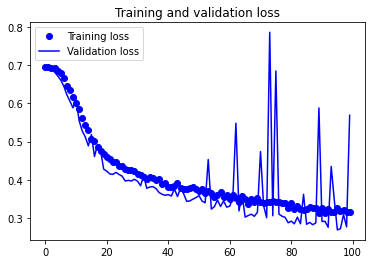

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 35ms/step - loss: 0.6585 - acc: 0.6339
0.6339285969734192
[[ 56 123]
 [  0 157]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 1s 36ms/step - loss: 0.3438 - acc: 0.8512
0.851190447807312
[[157  22]
 [ 28 129]]


11/11 [==============================] - 1s 59ms/step - loss: 0.3066 - acc: 0.8810
0.8809523582458496
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       179
           1       0.86      0.89      0.87       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336



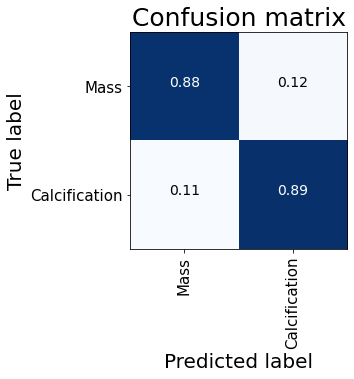

In [ ]:
network_name = "SimpleAlexNet_7_best.h5"
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc"
model = keras.models.load_model(os.path.join(path, network_name))
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
print(sklearn.metrics.classification_report(test_labels, pred_labels))

# **2.2: TRAIN A NETWORK FROM SCRATCH FOR BENIGN AND MALIGNANT DIAGNOSIS**





# Prepare Learning Dataset

In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels
 
images, labels= load_training()
images = np.expand_dims(images, axis = 3)
print("Training set loaded")
print("Images:" + str(np.shape(images)))
print("Labels:" + str(np.shape(labels)))
print() 

test_images, test_labels = load_test()
test_images = np.expand_dims(test_images, axis = 3)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

Training set loaded
Images:(5352, 150, 150, 1)
Labels:(5352,)

Test set loaded
Test Images:(672, 150, 150, 1)
Test Labels:(672,)


In [ ]:
#TRAIN/VALIDATION SET
#Extract all abnormalities indexes
abn_indexes = np.where(labels != 0)

#Extract all anormalities images
abn_images = images[abn_indexes]
abn_labels = labels[abn_indexes]

#Change labels according to Benign and Malignant
abn_labels = np.where(np.logical_or(abn_labels == 1, abn_labels == 3), 0, abn_labels)
abn_labels = np.where(np.logical_or(abn_labels == 2, abn_labels == 4), 1, abn_labels)

#Split between training and validation
train_images, validation_images, train_labels, validation_labels = train_test_split(abn_images, abn_labels, test_size=0.2, shuffle= True)

train_class0 = (train_labels == 0).sum()
train_class1 = (train_labels == 1).sum()
validation_class0 = (validation_labels == 0).sum()
validation_class1 = (validation_labels == 1).sum()

print("Training/Validation set split.")
print("Train Images:" + str(np.shape(train_images)))
print("Train Labels:" + str(np.shape(train_labels)))
print (str(train_class0) + " belonging to class 0 in the training set")
print (str(train_class1) + " belonging to class 1 in the training set")
print()
print("Validation Images:" + str(np.shape(validation_images)))
print("Validation Labels:" + str(np.shape(validation_labels)))
print (str(validation_class0) + " belonging to class 0 in the validation set")
print (str(validation_class1) + " belonging to class 1 in the validation set")

Training/Validation set split.
Train Images:(2140, 150, 150, 1)
Train Labels:(2140,)
1252 belonging to class 0 in the training set
888 belonging to class 1 in the training set

Validation Images:(536, 150, 150, 1)
Validation Labels:(536,)
316 belonging to class 0 in the validation set
220 belonging to class 1 in the validation set


In [ ]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Benign and Malignant
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 3), 0, test_labels)
test_labels = np.where(np.logical_or(test_labels == 2, test_labels == 4), 1, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")


Test Set
Test Images:(336, 150, 150, 1)
Test Labels:(336,)
219 belonging to class 0 in the test set
117 belonging to class 1 in the test set


In [ ]:
#Data Preprocessing
BATCH_SIZE = 32


#train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./65535)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   rescale=1./65535,
    rotation_range=30,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)


train_dataset = train_datagen.flow(
    train_images, 
    train_labels,
    batch_size=BATCH_SIZE, 
    shuffle = True
)

validation_dataset = test_datagen.flow(
    validation_images, 
    validation_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE, 
    shuffle = False
)

#SimpleCNN

In [ ]:
#Define a new model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 1)))                
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
#Name the model 
network_name = 'SimpleCNN_4.h5'
network_name_best = 'SimpleCNN_4_best.h5'


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 256)      

In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=200,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/200
67/67 [==============================] - 6s 69ms/step - loss: 0.6880 - acc: 0.5897 - val_loss: 0.6819 - val_acc: 0.5896
Epoch 2/200
67/67 [==============================] - 4s 66ms/step - loss: 0.6821 - acc: 0.5963 - val_loss: 0.6843 - val_acc: 0.5896
Epoch 3/200
67/67 [==============================] - 4s 63ms/step - loss: 0.6822 - acc: 0.5856 - val_loss: 0.6700 - val_acc: 0.5896
Epoch 4/200
67/67 [==============================] - 4s 63ms/step - loss: 0.6731 - acc: 0.5886 - val_loss: 0.6621 - val_acc: 0.5896
Epoch 5/200
67/67 [==============================] - 4s 63ms/step - loss: 0.6682 - acc: 0.6092 - val_loss: 0.6821 - val_acc: 0.5243
Epoch 6/200
67/67 [==============================] - 4s 64ms/step - loss: 0.6780 - acc: 0.5623 - val_loss: 0.6521 - val_acc: 0.6194
Epoch 7/200
67/67 [==============================] - 4s 64ms/step - loss: 0.6682 - acc: 0.6272 - val_loss: 0.6460 - val_acc: 0.6325
Epoch 8/200
67/67 [==============================] - 4s 63ms/step - loss: 0.

##MODEL EVALUATION

### Evaluation on validation set

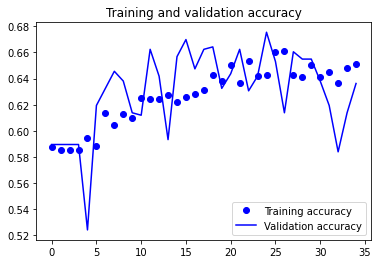

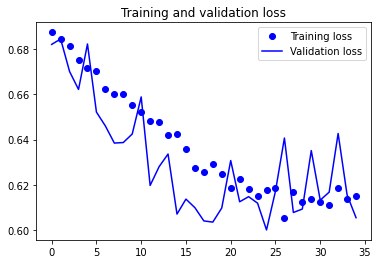

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 22ms/step - loss: 0.6268 - acc: 0.6161
0.6160714030265808
[[136  83]
 [ 46  71]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 11ms/step - loss: 0.6176 - acc: 0.6369
0.636904776096344
[[150  69]
 [ 53  64]]


#Vgg16





In [ ]:
vgg = VGG16(weights=None,
                  include_top=False,
                  input_shape=(150, 150, 1))
model = models.Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
#Name the model 
network_name = 'vgg16_4.h5'
network_name_best = 'vgg16_4_best.h5'

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14713536  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 18,908,865
Trainable params: 18,908,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = BATCH_SIZE,
      epochs=200,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/200
67/67 [==============================] - 17s 235ms/step - loss: 0.6906 - acc: 0.5819 - val_loss: 0.6838 - val_acc: 0.5896
Epoch 2/200
67/67 [==============================] - 16s 237ms/step - loss: 0.6834 - acc: 0.5937 - val_loss: 0.6836 - val_acc: 0.5896
Epoch 3/200
67/67 [==============================] - 16s 239ms/step - loss: 0.6846 - acc: 0.5865 - val_loss: 0.6824 - val_acc: 0.5896
Epoch 4/200
67/67 [==============================] - 16s 238ms/step - loss: 0.6847 - acc: 0.5855 - val_loss: 0.6810 - val_acc: 0.5896
Epoch 5/200
67/67 [==============================] - 16s 234ms/step - loss: 0.6811 - acc: 0.5867 - val_loss: 0.6793 - val_acc: 0.5896
Epoch 6/200
67/67 [==============================] - 16s 235ms/step - loss: 0.6825 - acc: 0.5806 - val_loss: 0.6772 - val_acc: 0.5896
Epoch 7/200
67/67 [==============================] - 16s 237ms/step - loss: 0.6752 - acc: 0.5950 - val_loss: 0.6694 - val_acc: 0.5896
Epoch 8/200
67/67 [==============================] - 16s 236ms

## MODEL EVALUATION

### Evaluation on validation set

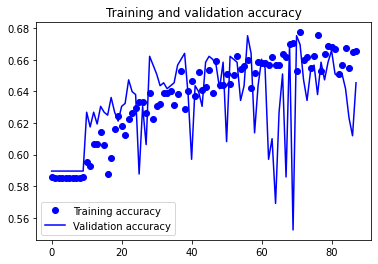

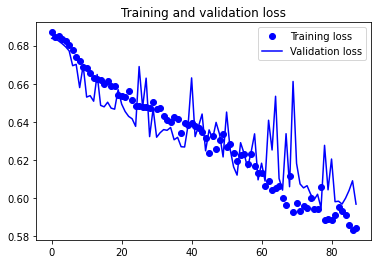

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 1s 65ms/step - loss: 0.6157 - acc: 0.6310
0.6309523582458496
[[149  70]
 [ 54  63]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 1s 66ms/step - loss: 0.6251 - acc: 0.6280
0.6279761791229248
[[130  89]
 [ 36  81]]


#SimpleAlexNet

In [ ]:
#Define a new model
model = models.Sequential()
model.add(layers.Conv2D(96, (3, 3), activation='relu',
                        input_shape=(150, 150, 1)))                
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(384, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
#Name the model 
network_name = 'SimpleAlexNet_5.h5'
network_name_best = 'SimpleAlexNet_5_best.h5'


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-6),
              metrics=['acc'])


CHECKPOINT_PATH = '/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal/' + network_name_best

my_callback = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10),
        tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor = 'val_loss', mode='auto', save_best_only=True)
]

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 96)      960       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 256)       221440    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 256)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 384)       885120    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 256)       884992    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 256)      

In [ ]:
#Train the model
history = model.fit(
      train_dataset,
      batch_size = 80,
      epochs=200,
      validation_data = validation_dataset,
      callbacks=my_callback
      )

Epoch 1/200
67/67 [==============================] - 8s 114ms/step - loss: 0.6856 - acc: 0.5850 - val_loss: 0.6852 - val_acc: 0.5896
Epoch 2/200
67/67 [==============================] - 8s 115ms/step - loss: 0.6853 - acc: 0.5850 - val_loss: 0.6851 - val_acc: 0.5896
Epoch 3/200
67/67 [==============================] - 8s 116ms/step - loss: 0.6852 - acc: 0.5850 - val_loss: 0.6851 - val_acc: 0.5896
Epoch 4/200
67/67 [==============================] - 8s 116ms/step - loss: 0.6852 - acc: 0.5850 - val_loss: 0.6850 - val_acc: 0.5896
Epoch 5/200
67/67 [==============================] - 8s 118ms/step - loss: 0.6853 - acc: 0.5850 - val_loss: 0.6850 - val_acc: 0.5896
Epoch 6/200
67/67 [==============================] - 8s 117ms/step - loss: 0.6852 - acc: 0.5850 - val_loss: 0.6849 - val_acc: 0.5896
Epoch 7/200
67/67 [==============================] - 8s 116ms/step - loss: 0.6850 - acc: 0.5850 - val_loss: 0.6849 - val_acc: 0.5896
Epoch 8/200
67/67 [==============================] - 8s 115ms/step - 

##MODEL EVALUATION

### Evaluation on validation set

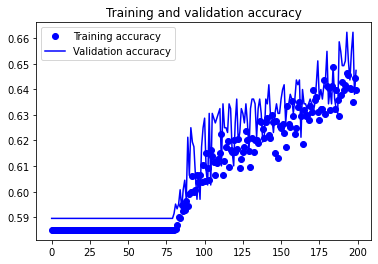

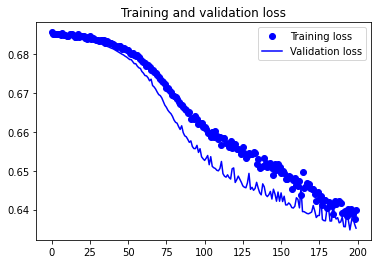

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

###Evaluation on test set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 0s 35ms/step - loss: 0.6352 - acc: 0.6696
0.6696428656578064
[[173  46]
 [ 65  52]]


In [ ]:
#SAVE THE MODEL (if you are satisfied)
dir_name ="/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, network_name))

In [ ]:
#load and test the "best model" 
path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal"
model_best = keras.models.load_model(os.path.join(path, network_name_best))

test_loss, test_accuracy = model_best.evaluate(test_dataset)
print(test_accuracy)

pred_labels = (model_best.predict(test_dataset) > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print(conf_matrix)

11/11 [==============================] - 1s 37ms/step - loss: 0.6302 - acc: 0.6696
0.6696428656578064
[[181  38]
 [ 73  44]]


#Some model comparision

Model comparision between the best Mass/Calcification classifiers.

In [ ]:
#Model load
scratch_path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc/"
alexnet_fromscratch = load_model(os.path.join(scratch_path, 'SimpleAlexNet_7_best.h5'))
vgg16_fromscratch = load_model(os.path.join(scratch_path, 'vgg16_4.h5'))

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

pred_vgg16=vgg16_fromscratch.predict(test_dataset)
fpr_vgg16fe, tpr_vgg16fe, thresholds_vgg16fe = roc_curve(test_labels,pred_vgg16)
auc_vgg16fe = auc(fpr_vgg16fe, tpr_vgg16fe)

pred_alexnet=alexnet_fromscratch.predict(test_dataset)
fpr_alexnet, tpr_alexnet, thresholds_alexnet = roc_curve(test_labels,pred_alexnet)
auc_alexnet = auc(fpr_alexnet, tpr_alexnet)

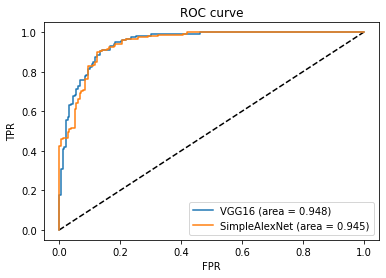

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg16fe, tpr_vgg16fe, label='VGG16 (area = {:.3f})'.format(auc_vgg16fe))
plt.plot(fpr_vgg16we, tpr_vgg16we, label='SimpleAlexNet (area = {:.3f})'.format(auc_vgg16we))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()